# 1. Load Data

In [11]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,classification_report,precision_score,recall_score,roc_curve, auc


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)


nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

path = '/content/drive/My Drive/Colab Notebooks/5153_Stackoverflow_RS/data/'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
data = pd.read_csv(path+'python_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190234 entries, 0 to 190233
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Id              190234 non-null  int64 
 1   Title           190234 non-null  object
 2   QuestionBody    190234 non-null  object
 3   AnswerBody      190234 non-null  object
 4   QuestionTime    190234 non-null  object
 5   AnswerTime      190234 non-null  object
 6   AnswerTimeDiff  190234 non-null  int64 
 7   Tags            190234 non-null  object
 8   UserId          190234 non-null  int64 
 9   UserReputation  190234 non-null  int64 
 10  UserPageViews   190234 non-null  int64 
 11  UserUpVote      190234 non-null  int64 
 12  UserDownVotes   190234 non-null  int64 
 13  BadgeNum        190234 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 20.3+ MB


# 2. Data Preprocessing

## 2.1 Create the label column for datasets

Visulize the 'AnswerTimeDiff' distribution and take a galance. The unit is based on minutes. We can find that the time range to get the answer is quite wide which convers from 0 mins to 1102664 mins (almost 765 days).

In [15]:
# data['AnswerTimeDiff'].value_counts()
print('Longest time: ',data['AnswerTimeDiff'].max())
print('Shortest time: ',data['AnswerTimeDiff'].min())
print('Average waiting time: ',data['AnswerTimeDiff'].mean())

Longest time:  1102664
Shortest time:  0
Average waiting time:  3336.379196147902


We can find that the median line is 26 mins for the waiting time distrubution.

In [16]:
data.describe()['AnswerTimeDiff']

count    1.902340e+05
mean     3.336379e+03
std      3.081305e+04
min      0.000000e+00
25%      9.000000e+00
50%      2.600000e+01
75%      1.300000e+02
max      1.102664e+06
Name: AnswerTimeDiff, dtype: float64

Take the user habit and customer experience factors into consideration. 30mins was determined as the boarder line for the class.

In [17]:
# Cut the bin by 30 mins
data['waiting_time_range'] = pd.cut(data['AnswerTimeDiff'],
                                    bins=[0,30,float('inf')],
                                    labels=['30Mins','Above30Mins'],
                                    right=False)

data['waiting_time_range'].value_counts()

30Mins         100733
Above30Mins     89501
Name: waiting_time_range, dtype: int64

We plot a pie chart to check whether the datasets is imbalanced dateset.
From the visilization result, can find the datasets is not imblanced.

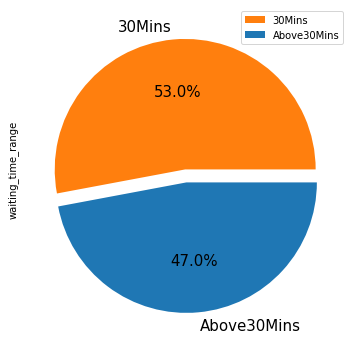

In [26]:
# Use pie chart to check whether the datasets is imbalanced dateset.
plt.figure(figsize=(6,6))
data['waiting_time_range'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=False, 
                                                  colors=['tab:orange', 'tab:blue'], textprops={'fontsize': 15})
plt.legend()
plt.show()

We deep dive the waiting time which are within 30 mins, and found actually most of use were able to  get the satisfied answers within 20 mins. 
Hence in order to provide a better user experience, it's necessary to detect that the user may have to wait for longer time and recommendate the similar questions to user to reference so that can avoid a negative experience.

(array([ 7316., 21228., 17805., 13373., 10616.,  8470.,  7035.,  5903.,
         4860.,  4127.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <a list of 10 Patch objects>)

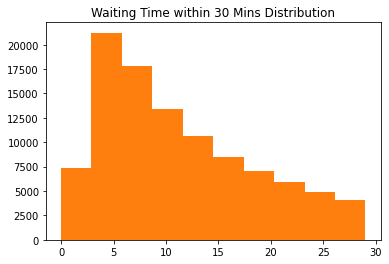

In [27]:
plt.title('Waiting Time within 30 Mins Distribution')
plt.hist(data[data['AnswerTimeDiff']<30].AnswerTimeDiff,color='tab:orange')

## 2.2 Text Cleaning

There are 3 text data columns inside the datasets. Prior to transform the text into vectorizor matrix. Text cleaning is necessary to be conducted by 4 steps as below.

1.Remove all the HTML tags

2.Remove punctuation

3.Pick up and store all the words from the text

4.Remove the stopwords

5.Consolidate all the words into one sentence.

In [28]:
# Data Cleaning

def clean_text(text):
    #Remove all the HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    #Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    #Pick up the words
    words = text.lower().split()
    #Remove stopwords
    words = [w for w in words if w not in stopwords]
    return ' '.join(words)

In [29]:
data['clean_title'] = data['Title'].apply(clean_text)
data['clean_question'] = data['QuestionBody'].apply(clean_text)
data['clean_answer'] = data['AnswerBody'].apply(clean_text)

data.head(5)

,Id,Title,QuestionBody,AnswerBody,QuestionTime,AnswerTime,AnswerTimeDiff,Tags,UserId,UserReputation,UserPageViews,UserUpVote,UserDownVotes,BadgeNum,waiting_time_range,clean_title,clean_question,clean_answer
0,53992234,How to rearrange subplots so that one is under...,<p>I am trying to code two plots such that one...,"<p>The way the numbers work in <a href=""https:...",2019-01-01 00:05:48,2019-01-01 00:12:23,7,<python><matplotlib><subplot>,10783174,89,24,5,0,3,30Mins,rearrange subplots one underneath,trying code two plots one plot underneath howe...,way numbers work subplots first provide number...
1,53992303,Python dominate package | add <style> to an html,<p>I'm trying to generate an html with the dom...,"<p>Is this what you are after? <a href=""https:...",2019-01-01 00:23:25,2019-01-01 04:38:00,255,<python><html><css><dominate>,9986139,211,65,128,6,1,Above30Mins,python dominate package add,trying generate html dominate package python f...,import dominate dominate tags import link scri...
2,53992436,How to assign without instantiating,<p>I need to remove a item from a list and the...,<p>Replace this line:</p>\n\n<pre><code>x=x2\n...,2019-01-01 01:08:26,2019-01-01 01:11:38,3,<python>,10659353,167,72,51,10,0,30Mins,assign without instantiating,need remove item list add position like x b c ...,replace line x x2 x x2 copy x x2 work
3,53992494,Dataframe filter with multi-index: return all ...,<p>I'm looking for the syntax to return all fi...,<p>You can use <code>groupby</code> on level =...,2019-01-01 01:23:31,2019-01-01 02:40:14,77,<python><pandas><multi-index>,10853168,21,3,0,0,0,Above30Mins,dataframe filter multi index return rows top i...,looking syntax return first tier data given mu...,use groupby level filter creating flag column ...
4,53992552,"Python/Flask - suddenly getting ""ImportError: ...",<p>I'm running into what I believe is a fairly...,"<p>You should add <code>""my_app.lib""</code> to...",2019-01-01 01:42:03,2019-01-01 09:26:23,464,<python><python-3.x><flask>,5203069,5630,439,2029,10,91,Above30Mins,python flask suddenly getting importerror modu...,running believe fairly common problem python a...,add app lib packages otherwise corresponding s...


#3.Feature Extraction

Feature engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. It is useful to improve the performance of machine learning algorithms and is often considered as applied machine learning.

In this section, serveral features will be extracted and created from raw data in order to get the better model performance.


## 3.1 Get the length of user input (Question title and Question body)

We defined 2 types of length and create 2 features for both of Question title and Question body. 
- Count the length of characters
- Count the number of words

In [34]:
# Length of question titles and bodies
# By char len
data['Title_Char_Length'] = data['clean_title'].str.len()
data['Question_Char_Length'] = data['clean_question'].str.len()
# By word count
data['Title_word_counts'] = data['clean_title'].apply(lambda x: len(x.split()))
data['Question_word_counts'] = data['clean_question'].apply(lambda x: len(x.split()))

data[['clean_title','clean_question','Title_Char_Length','Question_Char_Length','Title_word_counts','Question_word_counts']].head(5)

,clean_title,clean_question,Title_Char_Length,Question_Char_Length,Title_word_counts,Question_word_counts
0,rearrange subplots one underneath,trying code two plots one plot underneath howe...,33,1697,4,303
1,python dominate package add,trying generate html dominate package python f...,27,179,4,27
2,assign without instantiating,need remove item list add position like x b c ...,28,232,3,55
3,dataframe filter multi index return rows top i...,looking syntax return first tier data given mu...,76,883,12,191
4,python flask suddenly getting importerror modu...,running believe fairly common problem python a...,60,1344,8,221


## 3.2 Whether the question contains chunks of raw codes

We use whether the user input (QuestionBody) contains the HTML Tag \<code> as the crteria to judge hte question input contains the coding part and create a dummie feature called 'code_include'.

In [35]:
# Whether the question contains chunks of raw codes  -- <code>

# code_part = '|'.join(['#','(',')','=','def',':'])
# data['code_include'] = data['clean_question'].str.contains(code_part).map({True:1,False:0})

data['code_include'] = data['QuestionBody'].str.contains('<code>').map({True:1,False:0})
print(data['code_include'].value_counts())
data[['QuestionBody','code_include']].head(5)

1    179090
0     11144
Name: code_include, dtype: int64


,QuestionBody,code_include
0,<p>I am trying to code two plots such that one...,1
1,<p>I'm trying to generate an html with the dom...,0
2,<p>I need to remove a item from a list and the...,1
3,<p>I'm looking for the syntax to return all fi...,1
4,<p>I'm running into what I believe is a fairly...,1


## 3.3 Get the length of the coding part

In [37]:
# Len() of code part
def find_code(text):
  code_fragment = re.findall("<code>.*?</code>", text)
  code_num = len(code_fragment)
  code_length = len("".join(code_fragment))
  code_length -= code_num * 13
  return code_length, code_num

data['Question_code_len'] = data['QuestionBody'].apply(lambda x: find_code(x)[0])
data['Question_code_num'] = data['QuestionBody'].apply(lambda x: find_code(x)[1])

data[['QuestionBody','Question_code_len','Question_code_num']].head(5)

,QuestionBody,Question_code_len,Question_code_num
0,<p>I am trying to code two plots such that one...,0,0
1,<p>I'm trying to generate an html with the dom...,0,0
2,<p>I need to remove a item from a list and the...,12,5
3,<p>I'm looking for the syntax to return all fi...,99,2
4,<p>I'm running into what I believe is a fairly...,124,6


## 3.4 To check if the Question Titile is in question format

We use whether the user input (QuestionTitle) start witht the question word like 'how','what','why','How','What' and 'Why' as the crteria to judge whether user input question in question foramt and create a dummie feature called 'Tilte_in_question_format'.

In [39]:
# Whether the question title is in a question format: Start with How/What/Why...
# question_part = '|'.join(['how','what','why','How','What','Why'])
question_part = ['how','what','why','How','What','Why']
# data['Tilte_in_question_format'] = data['clean_title'].str.endswith("?").map({True:1,False:0})

data['Tilte_in_question_format'] = data['Title'].str.startswith(tuple(question_part)).map({True:1,False:0})
data['Tilte_in_question_format'].value_counts()

data[['Title','Tilte_in_question_format']].head(5)

,Title,Tilte_in_question_format
0,How to rearrange subplots so that one is under...,1
1,Python dominate package | add <style> to an html,0
2,How to assign without instantiating,1
3,Dataframe filter with multi-index: return all ...,0
4,"Python/Flask - suddenly getting ""ImportError: ...",0


## 3.5 Prcessing Tags

Tags is oen of the key features among all the columns. It was labelled by the users based on their topics. 

In this section, we processed this feature by 3 methods.


### 3.5.1 Generate 100 dummie columns for top 100 tags

- Consolidate all the tags from each input and generate the tag-set by using set() to keep the unique tags.
- To caculate the frequency of each tag in datasets.
- Select the top 100 high frequecy tags as most important 100 features and use it generate 100 dummie columns for them respectively.

In [40]:
# Processing Tags
# Generate Tag-Set

all_tags = []
for item in data['Tags'].astype(str):
    contents = item[1:-1].split('>')
    for tag in contents:
        add_tag = tag.strip("<")
        all_tags.append(add_tag)

# Remove duplicate tags
tags_list = list(set(all_tags))
print(f'Total {len(tags_list)} unique tags')

# Caculate the frequency of each tag in datasets.
tag_count = {i:all_tags.count(i) for i in tags_list}
print(tag_count)

# Store the frequency into Dataframe
tag_count_df = pd.DataFrame.from_dict(tag_count,orient='index')
tag_count_df = tag_count_df.reset_index().sort_values(by=0,ascending=False).rename(columns={'index':'tag',0:'count'})
# tag_count_df.copy().to_csv(f'{path}tags_counter.csv',index=False)

Total 10596 unique tags
{'wayland': 1, 'vin': 1, 'weighted-average': 23, 'named-entity-recognition': 31, 'mediawiki-api': 6, 'wordpress-theming': 1, 'pep8-checker': 2, 'styling': 13, 'bankid': 1, 'asyncsocket': 1, 'path-parameter': 1, 'ctypes': 219, 'super': 54, 'django-forms': 432, 'not-operator': 1, 'absolute-value': 3, 'plotly': 901, 'password-checker': 1, 'autokey': 3, 'pipfile': 3, 'scikit-learn': 2627, 'e-ink': 1, 'vte': 1, 'html-pdf': 1, 'attributes': 140, 'built-in-types': 1, 'qdapregex': 1, 'login': 5, 'qpainterpath': 1, 'blas': 4, 'weasyprint': 8, 'bot-framework-composer': 1, 'eager': 1, 'hashable': 5, 'x-sendfile': 1, 'formattable': 2, 'evdev': 2, 'hashbytes': 1, 'pearson-correlation': 20, 'active-window': 1, 'multiline': 12, 'nd4j': 1, 'supervisord': 8, 'nmf': 2, 'hg-git': 1, 'abbreviation': 3, 'qgraphicstextitem': 2, 'django-select2': 3, 'kube-apiserver': 1, 'windows-administration': 1, 'flask-appbuilder': 7, 'mser': 5, 'fasta': 22, 'spinner': 4, 'xhtml2pdf': 2, 'fpdf': 10

In [ ]:
# Backup the counter
tag_count_df = pd.read_csv(f'{path}tags_counter.csv')
tag_count_df.head(5)

Pick up the top 100 tags from the counter and use each row to compare with this tag list and generate the respective dummie column.

In [41]:
# Generate the dummie columns for top 100 tags
# tag_count_df = pd.read_csv(f'{path}tags_counter.csv')

top100_tags = tag_count_df.sort_values(by='count',ascending=False).head(100)['tag']

for tag in top100_tags:
  # print(tag)
  data[tag] = data['Tags'].apply(lambda x: 1 if tag in x else 0)

data.head()

,Id,Title,QuestionBody,AnswerBody,QuestionTime,AnswerTime,AnswerTimeDiff,Tags,UserId,UserReputation,UserPageViews,UserUpVote,UserDownVotes,BadgeNum,waiting_time_range,clean_title,clean_question,clean_answer,Title_Char_Length,Question_Char_Length,Title_word_counts,Question_word_counts,code_include,Question_code_len,Question_code_num,...,tensorflow2.0,performance,indexing,file,tuples,multithreading,kivy,group-by,xml,pytest,anaconda,sqlite,recursion,merge,discord,random,multiprocessing,numpy-ndarray,computer-vision,conv-neural-network,time-series,split,python-asyncio,python-imaging-library,windows
0,53992234,How to rearrange subplots so that one is under...,<p>I am trying to code two plots such that one...,"<p>The way the numbers work in <a href=""https:...",2019-01-01 00:05:48,2019-01-01 00:12:23,7,<python><matplotlib><subplot>,10783174,89,24,5,0,3,30Mins,rearrange subplots one underneath,trying code two plots one plot underneath howe...,way numbers work subplots first provide number...,33,1697,4,303,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53992303,Python dominate package | add <style> to an html,<p>I'm trying to generate an html with the dom...,"<p>Is this what you are after? <a href=""https:...",2019-01-01 00:23:25,2019-01-01 04:38:00,255,<python><html><css><dominate>,9986139,211,65,128,6,1,Above30Mins,python dominate package add,trying generate html dominate package python f...,import dominate dominate tags import link scri...,27,179,4,27,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53992436,How to assign without instantiating,<p>I need to remove a item from a list and the...,<p>Replace this line:</p>\n\n<pre><code>x=x2\n...,2019-01-01 01:08:26,2019-01-01 01:11:38,3,<python>,10659353,167,72,51,10,0,30Mins,assign without instantiating,need remove item list add position like x b c ...,replace line x x2 x x2 copy x x2 work,28,232,3,55,1,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53992494,Dataframe filter with multi-index: return all ...,<p>I'm looking for the syntax to return all fi...,<p>You can use <code>groupby</code> on level =...,2019-01-01 01:23:31,2019-01-01 02:40:14,77,<python><pandas><multi-index>,10853168,21,3,0,0,0,Above30Mins,dataframe filter multi index return rows top i...,looking syntax return first tier data given mu...,use groupby level filter creating flag column ...,76,883,12,191,1,99,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,53992552,"Python/Flask - suddenly getting ""ImportError: ...",<p>I'm running into what I believe is a fairly...,"<p>You should add <code>""my_app.lib""</code> to...",2019-01-01 01:42:03,2019-01-01 09:26:23,464,<python><python-3.x><flask>,5203069,5630,439,2029,10,91,Above30Mins,python flask suddenly getting importerror modu...,running believe fairly common problem python a...,add app lib packages otherwise corresponding s...,60,1344,8,221,1,124,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.5.2 Get the number of tags for each question input.



In [42]:
# Convert list of tags into list
data['tags_text'] = data['Tags'].str.replace('<','').str.replace('>',' ').str.strip()
# data['tags_text'][:5]

# No. of Tags
data['tag_numbers']= data['tags_text'].apply(lambda x: len(x.split(' ')))
# data['tag_numbers']

### 3.5.3 Caculate the average rank socre for each input's tags.

In [44]:
# Rank Sum(Frequency)/ len(Tags)
def calculate_average_rank_score(text):
  tag_lst = text.split(' ')
  score = round(sum([tag_count[tag] for tag in tag_lst])/len(tag_lst),2)
  return score
 
data['Tag_Score'] = data['tags_text'].apply(calculate_average_rank_score)

### 3.5.4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


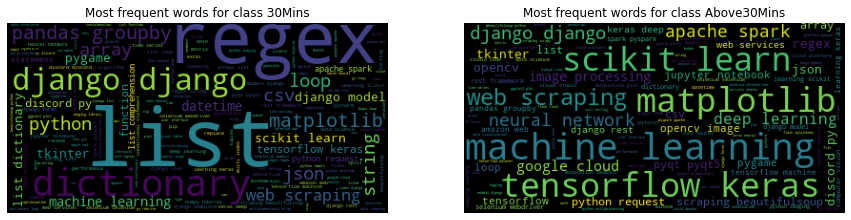

In [46]:
import nltk
nltk.download('punkt')
from wordcloud import WordCloud

def token(text):
    tokens = word_tokenize(text)
    return [token for token in tokens]

def word_cloud_plot(series):
    plt.figure(figsize = (15,30))
    for i in range(2):
        plt.subplot(1,2,i+1)
        cls_text = series[data['waiting_time_range'] == data['waiting_time_range'].unique().tolist()[i]].apply(lambda k: ' '.join(k))
        w_cloud = WordCloud().generate(' '.join(cls_text.values))
        plt.imshow(w_cloud)
        plt.title('Most frequent words for class {}'.format(str(data['waiting_time_range'].unique().tolist()[i])))
        plt.axis('off')

#Remove most commonly shared tags : {'dataframe', 'numpy', 'pandas', 'python', 'python-3.x'}
freq_tags = {'dataframe', 'numpy', 'pandas', 'python', 'python-3.x'}

def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in freq_tags])

data["tags_text_new"] = data['tags_text'].apply(lambda text: remove_freqwords(text))
data_tag = data['tags_text_new'].apply(lambda x: token(np.str_(x)))
word_cloud_plot(data_tag)


In [48]:
from collections import Counter
# 1. Get top 100 most frequent tags for class 0 (<30 mins)
cnt = Counter()
for text in data['tags_text_new'][data['waiting_time_range']=='30Mins'].values:
    for word in text.split():
        cnt[word] += 1
        
class0_top100 = [w for (w, wc) in cnt.most_common(100)]

# 2. Get top 100 most frequent tags for class 1 (>30 mins)
cnt = Counter()
for text in data['tags_text_new'][data['waiting_time_range']=='Above30Mins'].values:
    for word in text.split():
        cnt[word] += 1
        
class1_top100 = [w for (w, wc) in cnt.most_common(100)]

In [49]:
# 3. Get the whole set of tags for each of the two classe
tags_class0 = []
for item in data['tags_text_new'][data['waiting_time_range']=='30Mins']:
    contents = item.split()
    for tag in contents:
        tags_class0.append(tag)

tags_class0 = list(set(tags_class0))

tags_class1 = []
for item in data['tags_text_new'][data['waiting_time_range']=='Above30Mins']:
    contents = item.split()
    for tag in contents:
        tags_class1.append(tag)

tags_class1 = list(set(tags_class1))

In [50]:
# 4. Get the unique set of tags for each of two class
# Unique set
set_class0 = list(set(tags_class0) - set(tags_class1))
set_class1 = list(set(tags_class1) - set(tags_class0))

# 5. Get the final tag set, which is the union of top 100 frequet set and the unique set
# Frequet set + Unique set
set_class0 = list(set(set_class0).union(set(class0_top100)))
set_class1 = list(set(tags_class1).union(set(class1_top100)))

def class0_set_count(text):
    x = []
    for tag in text.split():
        if tag in set_class0:
            x.append(tag)
    return len(x)


def class1_set_count(text):
    x = []
    for tag in text.split():
        if tag in set_class1:
            x.append(tag)
    return len(x)

# 6. Get two features: tag_class0_number, tag_class1_number
data['tag_class0_numbers']= data['tags_text'].apply(lambda x:  class0_set_count(x))
data['tag_class1_numbers']= data['tags_text'].apply(lambda x:  class1_set_count(x))

data[['tags_text','tag_class0_numbers','tag_class1_numbers']]

,tags_text,tag_class0_numbers,tag_class1_numbers
0,python matplotlib subplot,1,2
1,python html css dominate,1,3
2,python,0,0
3,python pandas multi-index,1,1
4,python python-3.x flask,1,1
...,...,...,...
190229,python numpy machine-learning scikit-learn gra...,2,3
190230,python tensorflow keras semantic-segmentation,2,3
190231,python algorithm numpy matrix linear-algebra,2,3
190232,python python-3.x isinstance,0,1


## 3.6 Extraction from Question Time

We create the new feature whether the user submit the question in workdays in dummie column called 'Weekday' based on 'QuestionTime'.

In [45]:
# Time: Whether Weekday
import datetime as dt
data['QuestionTime'][:2]

data['QuestionTime'] = pd.to_datetime(data['QuestionTime'])
data['Weekday'] = data['QuestionTime'].dt.weekday.apply(lambda x: 1 if x<5 else 0)

In [ ]:
# Backup Point
data.copy().to_csv(f'{path}python_data_v8.csv',index=False)

# 4. Classification Models

In [51]:
# Load Data from backup file
data = pd.read_csv(f'{path}python_data_v8.csv')
tag_count_df = pd.read_csv(f'{path}tags_counter.csv')
# data.sample(5)

## 4.1 Prepare the training and test datasets for model training and prediction

In [52]:
# data.columns

tag_dummie_cols = tag_count_df['tag'].str.strip()[:100].values.tolist()
feature_cols = ['code_include', 'Tilte_in_question_format','Weekday']

# dummie_cols = feature_cols
dummie_cols = feature_cols + tag_dummie_cols

numerical_cols = ['UserReputation',
                  'UserPageViews',
                  'UserUpVote',
                  'UserDownVotes',
                  'BadgeNum',
                  'Title_Char_Length',
                  'Question_Char_Length',
                  'Title_word_counts',
                  'Question_word_counts','tag_numbers','Tag_Score','Question_code_num','Question_code_len']

drop_cols = ['Title','QuestionBody','AnswerBody','QuestionTime','clean_answer','clean_title',
             'AnswerTime','AnswerTimeDiff','Tags','UserId','waiting_time_range','tags_text',
             'Id']

X = data.drop(columns = drop_cols)
y = data['waiting_time_range'].astype('U')


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)

We design a function which is convinient to evaluate the performance of various model prediction.

In [53]:
# Function use to measure the performance of various model prediction.
def print_precison_recall_f1(y_true, y_pre):
    print(classification_report(y_true, y_pre))
    f1 = round(f1_score(y_true, y_pre, average='micro'), 2)
    p = round(precision_score(y_true, y_pre, average='micro'), 2)
    r = round(recall_score(y_true, y_pre, average='micro'), 2)
    print("Precision: {}, Recall: {}, F1: {} ".format(p, r, f1))

## 4.2 Text Processing Methods with various classification models


In this section we're going transfrom the user input('QuestionBody') by using 3 different text processing methods with the combination of 3 classification models.

Text processing Methods:
- TF-IDF   --- TfidfVectorizer
- BOW      --- CountVectorizer
- Word2Vec --- gensim.models.word2vec 

Classification Models:

- Multinomial Bayes
- LightGBM
- Neural Networks


In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

# X_train_other_feature = csr_matrix(X_train.drop(columns=['Id','clean_question']).values)

X_train_dummie_feature = csr_matrix(X_train[dummie_cols].values)
X_test_dummie_feature = csr_matrix(X_test[dummie_cols].values)

X_train_numerical_feature = csr_matrix(X_train[numerical_cols].values)
X_test_numerical_feature = csr_matrix(X_test[numerical_cols].values)

X_train_feature = hstack([X_train_dummie_feature,X_train_numerical_feature])
X_test_feature = hstack([X_test_dummie_feature,X_test_numerical_feature])

X_train_feature,X_test_feature

(<152187x116 sparse matrix of type '<class 'numpy.float64'>'
 	with 2382582 stored elements in COOrdinate format>,
 <38047x116 sparse matrix of type '<class 'numpy.float64'>'
 	with 595555 stored elements in COOrdinate format>)

## 4.2.1 Using TFIDF Method 

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,3), max_features=500)

X_train_tran = vec.fit_transform(X_train['clean_question'].astype('U'))
X_test_tran = vec.transform(X_test['clean_question'].astype('U'))

display(X_train_tran,X_test_tran)

from sklearn.feature_selection import f_classif
f_classif(X_train_tran,y_train)


from sklearn.feature_selection import SelectKBest
X_train_tran = X_train_tran.astype(np.float32)
X_test_tran = X_test_tran.astype(np.float32)

# Feature selector, pick best K features
selector = SelectKBest(f_classif, k=min(20000,X_train_tran.shape[1]))
selector.fit(X_train_tran,y_train)

# Using SelectKBest selector transform the training and test datasets (Feature Selection)
X_train_tran = selector.transform(X_train_tran)
X_test_tran = selector.transform(X_test_tran)

# Combine other features into one martix for final model training
X_train_tran = hstack([X_train_tran,X_train_feature])
X_test_tran = hstack([X_test_tran,X_test_feature])

<152187x500 sparse matrix of type '<class 'numpy.float64'>'
	with 4720086 stored elements in Compressed Sparse Row format>

<38047x500 sparse matrix of type '<class 'numpy.float64'>'
	with 1187661 stored elements in Compressed Sparse Row format>

### 4.2.1.1 TF-IDF + Bayes

In [ ]:
# Multinomial Bayes
from sklearn.naive_bayes import MultinomialNB

bayes_clf = MultinomialNB()
bayes_clf.fit(X_train_tran, y_train)

y_pred = bayes_clf.predict(X_test_tran)

print(f'Accuracy for MultinomialNB is: \n')
print_precison_recall_f1(y_test,y_pred)


Accuracy for MultinomialNB is: 

              precision    recall  f1-score   support

      30Mins       0.59      0.77      0.67     20060
 Above30Mins       0.62      0.41      0.49     17987

    accuracy                           0.60     38047
   macro avg       0.60      0.59      0.58     38047
weighted avg       0.60      0.60      0.59     38047

Precision: 0.6, Recall: 0.6, F1: 0.6 


### 4.2.1.2 TF-IDF + LightGBM

In [ ]:
# Using LightGBM with TFIDF and other features
from lightgbm import LGBMClassifier

lgbm_classifier = LGBMClassifier()

params_lgbm = {
    'learning_rate' : [0.05,0.1],
    #'max_depth':[6,10],
    #'min_child_samples': [23, 26],
    #'feature_fraction': [0.3, 0.4],
    #'num_leaves': [100,150],
    #'subsample': [0.4, 0.8], 
    #'colsample_bytree': [0.4, 0.6],
    'reg_alpha':[0.4,0.7],
    'reg_lambda':[0.4,0.7]

}

gs_lgbm = GridSearchCV(estimator=lgbm_classifier, 
                 param_grid=params_lgbm, 
                 cv=5,
                 n_jobs = -1, 
                 scoring='f1_macro') 

gs_lgbm.fit(X_train_tran, y_train)

lgbm_para = gs_lgbm.best_params_
print('Best Para set is: ', lgbm_para)

y_pred = gs_lgbm.predict(X_test_tran)

print(f'Accuracy for LightGBM is: \n')
print_precison_recall_f1(y_test,y_pred)

{'learning_rate': 0.1, 'reg_alpha': 0.7, 'reg_lambda': 0.4}

In [ ]:
# Using LightGBM  -- Ignore the GridSearchCV
# {'learning_rate': 0.1, 'reg_alpha': 0.7, 'reg_lambda': 0.4}
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier(
    learning_rate = 0.1,
    #colsample_bytree = lgbm_para['colsample_bytree'],
    #feature_fraction = lgbm_para['feature_fraction'],
    #num_leaves = lgbm_para['num_leaves'],
    #subsample = lgbm_para['subsample'],
    #max_depth = lgbm_para['max_depth'],
    #min_child_samples = lgbm_para['min_child_samples'],
    reg_alpha = 0.7,
    reg_lambda = 0.4)

lgbm_model = lgbm.fit(X_train_tran, y_train)
y_pred = lgbm_model.predict(X_test_tran)

print(f'Accuracy for LightGBM is: \n')
print_precison_recall_f1(y_test,y_pred)


Accuracy for LightGBM is: 

              precision    recall  f1-score   support

      30Mins       0.72      0.72      0.72     20060
 Above30Mins       0.69      0.69      0.69     17987

    accuracy                           0.70     38047
   macro avg       0.70      0.70      0.70     38047
weighted avg       0.70      0.70      0.70     38047

Precision: 0.7, Recall: 0.7, F1: 0.7 


## 4.2.2 Using Bag-of-Words(BOW)

In [ ]:
# Using CountVectzier

# data['clean_question'] = 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# 抽取bag of words特征(用sklearn的CountVectorizer)

vectorizer = CountVectorizer(max_features = 10000) 
# train_data_features = vectorizer.fit_transform(data['clean_question']).toarray()
# train_data_features.shape
# 词袋模型 190234 条数据 Dimension = 100000

X_train_tran = vectorizer.fit_transform(X_train['clean_question'].astype('U'))
X_test_tran = vectorizer.transform(X_test['clean_question'].astype('U'))

from sklearn.feature_selection import f_classif
f_classif(X_train_tran,y_train)


from sklearn.feature_selection import SelectKBest

X_train_tran = X_train_tran.astype(np.float32)
X_test_tran = X_test_tran.astype(np.float32)

# Feature selector, pick best K features
selector = SelectKBest(f_classif, k=min(20000,X_train_tran.shape[1]))
selector.fit(X_train_tran,y_train)


X_train_tran = selector.transform(X_train_tran)
X_test_tran = selector.transform(X_test_tran)


X_train_tran = hstack([X_train_tran,X_train_feature])
X_test_tran = hstack([X_test_tran,X_test_feature])

In [ ]:
# type(train_data_features)  ---> numpy.ndarray
# X_train_feature,X_test_feature


numpy.ndarray

### 4.2.2.1 Bag Of Words(BOW) + Multinomial Bayes

In [ ]:
# Multinomial Bayes
from sklearn.naive_bayes import MultinomialNB

bayes_clf = MultinomialNB()
bayes_clf.fit(X_train_tran, y_train)

y_pred = bayes_clf.predict(X_test_tran)

print(f'Accuracy for MultinomialNB is: \n')
print_precison_recall_f1(y_test,y_pred)


Accuracy for MultinomialNB is: 

              precision    recall  f1-score   support

      30Mins       0.60      0.77      0.67     20060
 Above30Mins       0.62      0.42      0.50     17987

    accuracy                           0.60     38047
   macro avg       0.61      0.59      0.59     38047
weighted avg       0.61      0.60      0.59     38047

Precision: 0.6, Recall: 0.6, F1: 0.6 


### 4.2.2.2 Bag Of Words(BOW) + LightGBM

In [ ]:
# Using LightGBM with TFIDF and other features
from lightgbm import LGBMClassifier

lgbm_classifier = LGBMClassifier()

params_lgbm = {
    'learning_rate' : [0.05,0.1],
    #'max_depth':[6,10],
    #'min_child_samples': [23, 26],
    #'feature_fraction': [0.3, 0.4],
    #'num_leaves': [100,150],
    #'subsample': [0.4, 0.8], 
    #'colsample_bytree': [0.4, 0.6],
    'reg_alpha':[0.4,0.7],
    'reg_lambda':[0.4,0.7]

}

gs_lgbm = GridSearchCV(estimator=lgbm_classifier, 
                 param_grid=params_lgbm, 
                 cv=5,
                 n_jobs = -1, 
                 scoring='f1_macro') 

gs_lgbm.fit(X_train_tran, y_train)

lgbm_para = gs_lgbm.best_params_
print('Best Para set is: ', lgbm_para)

y_pred = gs_lgbm.predict(X_test_tran)

print(f'Accuracy for LightGBM is: \n')
print_precison_recall_f1(y_test,y_pred)

KeyboardInterrupt: ignored

In [ ]:
# Using LightGBM  -- Ignore the GridSearchCV
# {'learning_rate': 0.1, 'reg_alpha': 0.7, 'reg_lambda': 0.4}
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier(
    learning_rate = 0.1,
    #colsample_bytree = lgbm_para['colsample_bytree'],
    #feature_fraction = lgbm_para['feature_fraction'],
    #num_leaves = lgbm_para['num_leaves'],
    #subsample = lgbm_para['subsample'],
    #max_depth = lgbm_para['max_depth'],
    #min_child_samples = lgbm_para['min_child_samples'],
    reg_alpha = 0.7,
    reg_lambda = 0.4)

lgbm_model = lgbm.fit(X_train_tran, y_train)
y_pred = lgbm_model.predict(X_test_tran)

print(f'Accuracy for LightGBM is: \n')
print_precison_recall_f1(y_test,y_pred)


Accuracy for LightGBM is: 

              precision    recall  f1-score   support

      30Mins       0.72      0.73      0.72     20060
 Above30Mins       0.69      0.68      0.69     17987

    accuracy                           0.71     38047
   macro avg       0.71      0.71      0.71     38047
weighted avg       0.71      0.71      0.71     38047

Precision: 0.71, Recall: 0.71, F1: 0.71 


## 4.2.3 Using Word2Vec

In [ ]:
%%time
import nltk
nltk.download('punkt')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def split_sentences(text):
    raw_sentences = tokenizer.tokenize(text.strip())
    sentences = [s for s in raw_sentences if s]
    return sentences

question_part = data['clean_question']
question_token = question_part.apply(split_sentences)

# sentences = sum(question_token, [])
# print('{} questions -> {} sentences'.format(len(question_part), len(sentences)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 31.5 s, sys: 197 ms, total: 31.7 s
Wall time: 31.6 s


In [ ]:
question_token

0         [trying code two plots one plot underneath how...
1         [trying generate html dominate package python ...
2         [need remove item list add position like x b c...
3         [looking syntax return first tier data given m...
4         [running believe fairly common problem python ...
                                ...                        
190229    [believe implemented gd correctly partially ba...
190230    [semantic segmentation task predict 5 channel ...
190231    [say exists set x row vectors dimension 1 x se...
190232    [class point def init self x obj 0 0 isinstanc...
190233    [put initial condition ode specific time point...
Name: clean_question, Length: 190234, dtype: object

In [ ]:
%%time
sentences_list = []

# each word is an element and store into the list
for key, sentences in question_token.items():
  for line in sentences:
    sentences_list.append(nltk.word_tokenize(line))

CPU times: user 2min, sys: 1.22 s, total: 2min 2s
Wall time: 2min 1s


In [ ]:
# Set the paramters
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
model_name = '{}features_{}minwords_{}context.model'.format(num_features, min_word_count, context)

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences_list, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
# model.save(os.path.join('..', 'models', model_name))
model.save(f'/content/drive/My Drive/Colab Notebooks/5153_Stackoverflow_RS/{model_name}')

In [ ]:
%%time
def to_question_vector(text):
    global word_vec
    
    # review = clean_text(review, remove_stopwords=True)
    #print (review)
    #words = nltk.word_tokenize(review)
    word_vec = np.zeros((1,300))
    for word in text:
        #word_vec = np.zeros((1,300))
        if word in model:
            word_vec += np.array([model[word]])
    #print (word_vec.mean(axis = 0))
    return pd.Series(word_vec.mean(axis = 0))

question_data_features = data['clean_question'].apply(to_question_vector)
question_data_features.head(100)

CPU times: user 22min 27s, sys: 2min 6s, total: 24min 33s
Wall time: 22min 17s


In [ ]:
question_data_features.shape

(190234, 300)

In [ ]:
# Combine the X dataframe

X = pd.concat([question_data_features,data[numerical_cols],data[dummie_cols]],axis=1)
y = data['waiting_time_range'].astype('U')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)


In [54]:
# Backup point
# word2vec_df = pd.concat([X,y],axis=1)
# word2vec_df.shape
# word2vec_df.copy().to_csv(f'{path}Word2Vec.csv',index=False)

df = pd.read_csv(f'{path}Word2Vec.csv')
X = df.drop('waiting_time_range',axis=1)
y = df['waiting_time_range'].astype('U')

As there are negative value inside the DataFrame, Bayes models is not applicable for this method. Hence we can only use LightGBM and Nerual Network Models.

### 4.2.3.1 Word2Vec + LightGBM

In [55]:
# Using LightGBM  -- Ignore the GridSearchCV
# {'learning_rate': 0.1, 'reg_alpha': 0.7, 'reg_lambda': 0.4}
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2021)

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    learning_rate = 0.1,
    #colsample_bytree = lgbm_para['colsample_bytree'],
    #feature_fraction = lgbm_para['feature_fraction'],
    #num_leaves = lgbm_para['num_leaves'],
    #subsample = lgbm_para['subsample'],
    #max_depth = lgbm_para['max_depth'],
    #min_child_samples = lgbm_para['min_child_samples'],
    reg_alpha = 0.7,
    reg_lambda = 0.4)

lgbm_model = lgbm.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

print(f'Accuracy for LightGBM is: \n')
print_precison_recall_f1(y_test,y_pred)


Accuracy for LightGBM is: 

              precision    recall  f1-score   support

      30Mins       0.71      0.71      0.71     20060
 Above30Mins       0.68      0.68      0.68     17987

    accuracy                           0.70     38047
   macro avg       0.69      0.69      0.69     38047
weighted avg       0.70      0.70      0.70     38047

Precision: 0.7, Recall: 0.7, F1: 0.7 


### 4.2.3.2 Word2Vec + Neural Network



In [57]:
# NN
%%time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def create_model():
    model = Sequential()
    # model.add(Dense(60, input_dim=all_features.fit_transform(X_train).shape[1], activation='relu'))
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
  

    # Compile model
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    #adam
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

nn = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64)    

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

print(f'Accuracy for Neural Network is: \n')
print_precison_recall_f1(y_test,y_pred)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function f1_m at 0x7f8560535e60>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function f1_m at 0x7f8560535e60>. Note that functions defined in certain environments, like the interactive Python shell do